In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

In [ ]:
#Downloading MNIST from openml
from sklearn.datasets import fetch_openml
mnist = fetch_openml(data_id=554) # https://www.openml.org/d/554

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [ ]:
print("start problem 1")

start problem 1


In [ ]:
def plot_digits(data,img_size=28, rows=10):
  fig, ax = plt.subplots(rows, 10, figsize=(8, 8),
                          subplot_kw=dict(xticks=[], yticks=[]))
  fig.subplots_adjust(hspace=0.05, wspace=0.05)
  for i, axi in enumerate(ax.flat):
      if i < data.shape[0]:
        im = axi.imshow(data[i].reshape(img_size, img_size), cmap='Greys')
      im.set_clim(0, 16)

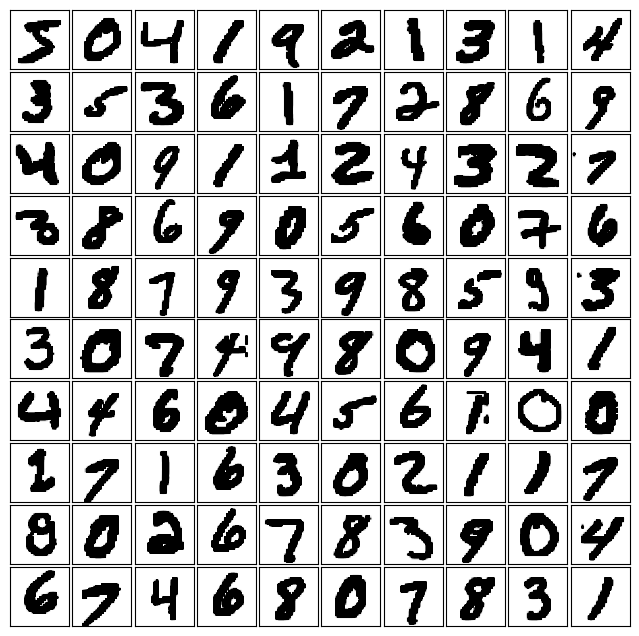

In [ ]:
plot_digits(mnist.data.values)

In [ ]:
def plot_digits_with_predictions(model, data, labels, img_size=28, rows=10):
    fig, ax = plt.subplots(rows, 10, figsize=(16, 20),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=2.0, wspace=0.01)
    for i, axi in enumerate(ax.flat):
        if i < data.shape[0]:
          im = axi.imshow(data[i].reshape(img_size, img_size), cmap='Greys')
          pred_label = model(torch.tensor(data[i]).float()).item()
          drawColor = 'black'
          if (pred_label>0) != (labels[i]>0.5):
            drawColor = 'red'
          axi.set_title("label:{}\npred:{:1.2f}".format(labels[i],pred_label), color=drawColor)
        im.set_clim(0, 16)

In [ ]:
mnist_training_data = mnist.data.values[0:60000,:] #Keep the first 60000 samples for training
mnist_training_labels = mnist.target.values[0:60000]
mnist_testing_data = mnist.data.values[60000:,:] #Test on the rest
mnist_testing_labels = mnist.target.values[60000:]

In [ ]:
mnist_testing_data.shape

(10000, 784)

In [ ]:
mnist_training_label_lucky =  np.expand_dims(1.0 * (np.logical_or(np.logical_or(mnist_training_labels == '3', mnist_training_labels == '7'), mnist_training_labels == '8')), 1)
mnist_testing_label_lucky = np.expand_dims(1.0 * (np.logical_or(np.logical_or(mnist_testing_labels == '3', mnist_testing_labels == '7'), mnist_testing_labels == '8')), 1)
mnist_testing_label_thr = np.expand_dims(1.0*(mnist_testing_labels=='3'),1)
mnist_testing_label_sev = np.expand_dims(1.0*(mnist_testing_labels=='7'),1)
mnist_testing_label_eig = np.expand_dims(1.0*(mnist_testing_labels=='8'),1)

In [ ]:
class NumpyDataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, input_array, target_output_array):
    'Initialization'
    self.input_tensor = torch.from_numpy(input_array).float()
    self.output_tensor = torch.from_numpy(target_output_array).float()

  def __len__(self):
      'Denotes the total number of samples'
      return len(self.input_tensor)

  def __getitem__(self, index):
      'Generates one sample of data'
      # Load data and get label
      X = self.input_tensor[index]
      y = self.output_tensor[index]

      return X, y

In [ ]:
training_dataset = NumpyDataset(mnist_training_data,mnist_training_label_lucky)
testing_dataset = NumpyDataset(mnist_testing_data,mnist_testing_label_lucky)
testing_dataset_thr = NumpyDataset(mnist_testing_data,mnist_testing_label_thr)
testing_dataset_sev = NumpyDataset(mnist_testing_data,mnist_testing_label_sev)
testing_dataset_eig = NumpyDataset(mnist_testing_data,mnist_testing_label_eig)

In [ ]:
def train(model,  data_generator, loss_function, optimizer):
  model.train() #updates any model layers that behave differently in training and execution
  avg_loss = 0
  num_batches = 0
  for i, (input_data, target_output) in enumerate(data_generator):
    optimizer.zero_grad()                            # Gradients need to be reset each batch
    prediction = model(input_data)                   # Forward pass: compute the output class given a image
    loss = loss_function(prediction, target_output)  # Compute the loss: difference between the output and correct result
    loss.backward()                                  # Backward pass: compute the gradients of the model with respect to the loss
    optimizer.step()
    avg_loss += loss.item()
    num_batches += 1
  return avg_loss/num_batches

In [ ]:
def test(model, test_loader, loss_function):
  model.eval() #updates any model layers that behave differently in training and execution
  test_loss = 0
  num_batches = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = model(data)
      test_loss += loss_function(output, target).item()
      pred = output.data.max(1, keepdim=True)[1]
      num_batches += 1
  test_loss /= num_batches
  #print('\nTest set: Avg. loss: {:.4f})\n'.format(test_loss))
  return test_loss

In [ ]:
def logResults(epoch, num_epochs, train_loss, train_loss_history, test_loss, test_loss_history, epoch_counter, print_interval=1000):
  if (epoch%print_interval == 0):  print('Epoch [%d/%d], Train Loss: %.4f, Test Loss: %.4f' %(epoch+1, num_epochs, train_loss, test_loss))
  train_loss_history.append(train_loss)
  test_loss_history.append(test_loss)
  epoch_counter.append(epoch)

In [ ]:
def graphLoss(epoch_counter, train_loss_hist, test_loss_hist, loss_name="Loss", start = 0):
  fig = plt.figure()
  plt.plot(epoch_counter[start:], train_loss_hist[start:], color='blue')
  plt.plot(epoch_counter[start:], test_loss_hist[start:], color='red')
  plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
  plt.xlabel('#Epochs')
  plt.ylabel(loss_name)

In [ ]:
def trainAndGraph(model, training_generator, testing_generator, loss_function, optimizer, num_epochs, learning_rate, logging_interval=1):
  #Arrays to store training history
  test_loss_history = []
  epoch_counter = []
  train_loss_history = []

  for epoch in range(num_epochs):
    avg_loss = train(model, training_generator, loss_function, optimizer)
    test_loss = test(model, testing_generator, loss_function)
    logResults(epoch, num_epochs, avg_loss, train_loss_history, test_loss, test_loss_history, epoch_counter, logging_interval)

  graphLoss(epoch_counter, train_loss_history, test_loss_history)

In [ ]:
def computeLabelAccuracy(model, data_loader, label_text=""):
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in data_loader:
      output = model(data)
      correct += (output>0).eq(target>0).sum()
  print('\n{}: Accuracy: {}/{} ({:.1f}%)'.format(
    label_text, correct, len(data_loader.dataset),
    100. * correct / len(data_loader.dataset)))

In [ ]:
class LinearClassifier(nn.Module):
    def __init__(self, img_w, img_h, numClasses):  #For binary predictions numClasses = 1 is fine
        super().__init__()
        self.flatSize = img_w*img_h
        self.img_w = img_w
        self.img_h = img_h
        self.linear1 = nn.Linear(self.flatSize, numClasses)

    def forward(self, x):
        x = x.view(-1,self.flatSize)  #Pytorch will replace -1 with the batch size
        x = self.linear1(x)
        return x

In [ ]:
def SigmoidLoss(output, target): #L2 Loss - same as nn.MSELoss()
   loss = torch.mean((torch.sigmoid(output) - target)**2)
   return loss

Loaded Data
Epoch [1/20], Train Loss: 0.1776, Test Loss: 0.1594
Epoch [6/20], Train Loss: 0.1380, Test Loss: 0.1335
Epoch [11/20], Train Loss: 0.1299, Test Loss: 0.1279
Epoch [16/20], Train Loss: 0.1321, Test Loss: 0.1290


LinearClassifier(
  (linear1): Linear(in_features=784, out_features=1, bias=True)
)

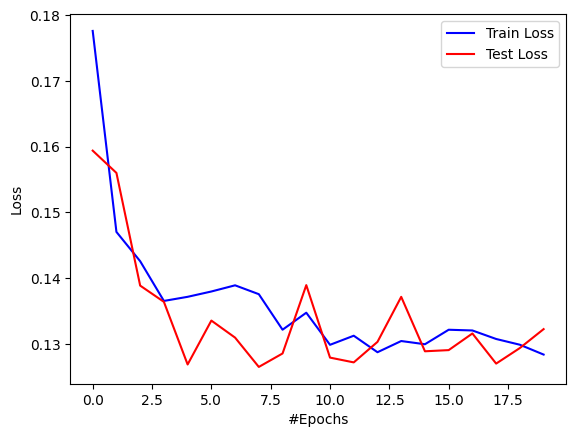

In [ ]:
#Training parameters
num_epochs = 20
print_interval = 5
learning_rate = 0.001
batch_size = 100

#MNIST images are 28x28
image_w = 28
image_h = 28

#Create model
predModel = LinearClassifier(image_w, image_h, 1)

#Set optimizer and loss function
model = predModel;
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) #or torch.optim.SGD
loss_function = SigmoidLoss #torch.nn.MSELoss() #Try the built-in MSELoss, it should be identical

#Load the data, and split it into batches
training_generator = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
testing_generator = torch.utils.data.DataLoader(testing_dataset, batch_size=batch_size)
testing_generator_thr = torch.utils.data.DataLoader(testing_dataset_thr, batch_size=batch_size)
testing_generator_sev = torch.utils.data.DataLoader(testing_dataset_sev, batch_size=batch_size)
testing_generator_eig = torch.utils.data.DataLoader(testing_dataset_eig, batch_size=batch_size)

print("Loaded Data")

trainAndGraph(model, training_generator, testing_generator, loss_function, optimizer, num_epochs, learning_rate, print_interval)
model

In [ ]:
computeLabelAccuracy(model, training_generator, "Training")
computeLabelAccuracy(model, testing_generator, "Test Lucky")
computeLabelAccuracy(model, testing_generator_thr, "Test 3")
computeLabelAccuracy(model, testing_generator_sev, "Test 7")
computeLabelAccuracy(model, testing_generator_eig, "Test 8")


Training: Accuracy: 52222/60000 (87.0%)

Test Lucky: Accuracy: 8671/10000 (86.7%)

Test 3: Accuracy: 7631/10000 (76.3%)

Test 7: Accuracy: 7599/10000 (76.0%)

Test 8: Accuracy: 7179/10000 (71.8%)


In [ ]:
print("start problem 2")

start problem 2


In [ ]:
print("start problem 3")

start problem 3


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import confusion_matrix

torch.set_printoptions(sci_mode=False)

In [ ]:
loss_function = nn.CrossEntropyLoss()
loss_function_sum = nn.CrossEntropyLoss(reduction='sum')

In [ ]:
mnist_training_labels_catigories = F.one_hot(torch.Tensor(torch.Tensor(mnist_training_labels.to_numpy().astype(int))).long()).numpy()
mnist_testing_labels_catigories = F.one_hot(torch.Tensor(torch.Tensor(mnist_testing_labels.to_numpy().astype(int))).long()).numpy()
training_dataset = NumpyDataset(mnist_training_data,mnist_training_labels_catigories)
testing_dataset = NumpyDataset(mnist_testing_data,mnist_testing_labels_catigories)

In [92]:
class Classifier_3Layers(nn.Module):
    def __init__(self, img_w, img_h, numClasses, layer_1, layer_2):  #For binary predictions numClasses = 1 is fine
        super().__init__()
        self.flatSize = img_w*img_h
        self.img_w = img_w
        self.img_h = img_h
        self.linear1 = nn.Linear(self.flatSize, 20)  #Multiple matrix "layers"
        self.linear2 = nn.Linear(20, 15)             #This is 784->20->15->10 ...
        self.linear3 = nn.Linear(15, numClasses)     #... try different options

    def forward(self, x):
        x = x.view(-1,self.flatSize)   #Pytorch will replace -1 with the batch size
        x = torch.abs(self.linear1(x)) # "abs" and/or "relu" are example of non-linear tranformations
        x = F.relu(self.linear2(x))    # 'relu' keeps positive numbers same, sets negative numbers to 0
        x = self.linear3(x)
        return x

In [ ]:
def plot_digits_with_mnist_predictions(model, data, labels, img_size=28, rows=10):
    fig, ax = plt.subplots(rows, 10, figsize=(16, 20),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=2.0, wspace=0.01)
    for i, axi in enumerate(ax.flat):
        if i < data.shape[0]:
          im = axi.imshow(data[i].reshape(img_size, img_size), cmap='Greys')
          pred_label = model(torch.tensor(data[i]).float()).max(1, keepdim=True)[1].item()
          true_label = np.argmax(labels[i])
          drawColor = 'black'
          if pred_label != true_label:
            drawColor = 'red'
          axi.set_title("label:{}\npred:{}".format(true_label,pred_label), color=drawColor)
        im.set_clim(0, 16)

In [ ]:
def computeLabelAccuracyM(networkModel, data_loader, label_text=""):
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in data_loader:
      output = networkModel(data)
      pred = output.data.max(1, keepdim=True)[1]  #Check if the maximum/largest output class matches the label
      true_labels = target.data.max(1, keepdim=True)[1]
      correct += pred.eq(true_labels.data.view_as(pred)).sum()
  print('\n{}: Accuracy: {}/{} ({:.1f}%)'.format(
    label_text, correct, len(data_loader.dataset),
    100. * correct / len(data_loader.dataset)))

In [ ]:
#Training parameters
num_epochs = 20
print_interval = 5
learning_rate = 0.001
batch_size = 200

#MNIST images are 28x28
image_w = 28
image_h = 28

layers = [20, 15, 40, 30, 80, 60]

for i in range(0, len(layers), 2):
  #Create model
  layer_1 = layers[i]
  layer_2 = layers[i+1]
  predModel = Classifier_3Layers(image_w, image_h, 10, layer_1, layer_2)

  #Set optimizer and loss function
  model = predModel;
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) #or torch.optim.SGD
  loss_function = nn.CrossEntropyLoss() #torch.nn.MSELoss() #Try the built-in MSELoss, it should be identical

  #Load the data, and split it into batches
  training_generator = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
  testing_generator = torch.utils.data.DataLoader(testing_dataset, batch_size=batch_size)

  print("Loaded Data")

  trainAndGraph(model, training_generator, testing_generator, loss_function, optimizer, num_epochs, learning_rate, print_interval)
  computeLabelAccuracyM(model, training_generator, "Train Set")
  computeLabelAccuracyM(model, testing_generator, "Test Set")



Loaded Data


ValueError: ignored

In [ ]:
print("start problem 4")

start problem 4


In [ ]:
"""loss_function = nn.CrossEntropyLoss()
loss_function_sum = nn.CrossEntropyLoss(reduction='sum')
mnist_training_labels_int = mnist_training_labels.to_numpy().astype(int)
mnist_testing_labels_int = mnist_testing_labels.to_numpy().astype(int)

# Convert labels to one-hot encoded vectors
mnist_training_labels_categories = F.one_hot(torch.Tensor(mnist_training_labels_int).long())
mnist_testing_labels_categories = F.one_hot(torch.Tensor(mnist_testing_labels_int).long())

# Convert to numpy arrays
mnist_training_labels_categories_numpy = mnist_training_labels_categories.numpy()
mnist_testing_labels_categories_numpy = mnist_testing_labels_categories.numpy()

# Create NumpyDataset
training_dataset = NumpyDataset(mnist_training_data, mnist_training_labels_categories_numpy)
testing_dataset = NumpyDataset(mnist_testing_data, mnist_testing_labels_categories_numpy)"""
print("hi")

hi


In [ ]:
#Training parameters
num_epochs = 20
print_interval = 5
learning_rate = 0.001
batch_size = 200

#MNIST images are 28x28
image_w = 28
image_h = 28

#Create model
layer_1 = layers[i]
layer_2 = layers[i+1]
predModel = Classifier_3Layers(image_w, image_h, 10, 40, 30)

 #Set optimizer and loss function
model = predModel;
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) #or torch.optim.SGD
loss_function = nn.CrossEntropyLoss() #torch.nn.MSELoss() #Try the built-in MSELoss, it should be identical

#Load the data, and split it into batches
training_generator = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
testing_generator = torch.utils.data.DataLoader(testing_dataset, batch_size=batch_size)

print("Loaded Data")

trainAndGraph(model, training_generator, testing_generator, loss_function, optimizer, num_epochs, learning_rate, print_interval)
computeLabelAccuracyM(model, training_generator, "Train Set")
computeLabelAccuracyM(model, testing_generator, "Test Set")

Loaded Data


ValueError: ignored

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Assuming model is your trained Classifier_3Layers_bad model
# Assuming testing_dataset is your testing dataset

# Set the model to evaluation mode
model.eval()

# Lists to store the most confident images and their corresponding labels
most_confident_images = []
most_confident_labels = []

# Loop through each digit (0-9)
for digit in range(10):
    # Filter the testing dataset for the current digit
    digit_indices = torch.nonzero(testing_dataset.output_tensor == digit).squeeze()

    # Extract the subset of the dataset for the current digit
    digit_data = testing_dataset.input_tensor[digit_indices]

    # Create a DataLoader for the subset
    digit_loader = torch.utils.data.DataLoader(digit_data, batch_size=len(digit_data))

    # Get the inputs and labels
    inputs, labels = next(iter(digit_loader))

    # Forward pass to get predictions
    outputs = model(inputs)

    # Use softmax to get probabilities
    probabilities = F.softmax(outputs, dim=1)

    # Get the index with the maximum probability for each image
    max_prob_indices = torch.argmax(probabilities, dim=1)

    # Find the image with the highest predicted probability
    most_confident_index = torch.argmax(probabilities[:, digit]).item()

    # Append the most confident image and label to the lists
    most_confident_images.append(inputs[most_confident_index])
    most_confident_labels.append(labels[most_confident_index])

# Display the most confident images for each digit
plt.figure(figsize=(15, 8))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(most_confident_images[i].squeeze(), cmap='gray')
    plt.title(f"Digit: {most_confident_labels[i].item()}")
    plt.axis('off')

plt.show()

ValueError: ignored